# Positron Emission Tomography (PET) reconstruction with Distributional Consistency (DC) loss
### Code for plotting figures

## Setup

In [1]:
# --- Set up import path ---
import sys, os

self_dir = os.getcwd()
src_path = os.path.abspath(os.path.join(self_dir, '..', 'src'))
sys.path.insert(0, src_path)

In [2]:
# --- Import libraries ---
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import numpy as np
import scipy
from scipy.ndimage import binary_fill_holes
import array_api_compat.torch as torch
import pickle

from utils.phantom import get_brainweb_phantom
from utils.plotting import plot_CDF_histogram, hide
from utils.metrics import *
from utils.projector import get_projector, get_binmashed_projector_forward_function, get_binmashed_projector_adjoint_function
from utils.losses import dc_loss_poisson
from utils.common_utils import fix_seed

plt.rcParams['image.interpolation'] = 'none'


          -  -  -  -  -  -  -  -   -  -  -  -
          P  A  R  A  L  L  E  L | P  R  O  J
          -  -  -  -  -  -  -  -   -  -  -  -


         Please consider citing our publication
      ---------------------------------------------
      Georg Schramm and Kris Thielemans:
      "PARALLELPROJ—an open-source framework for
       fast calculation of projections in
       tomography"
      Front. Nucl. Med., 08 January 2024
      Sec. PET and SPECT, Vol 3
      https://doi.org/10.3389/fnume.2023.1324562

 
    parallelproj C    lib: C:\Users\gw23\AppData\Local\miniforge3\envs\recon_pipeline\Library\bin\parallelproj_c.dll
    parallelproj CUDA lib: C:\Users\gw23\AppData\Local\miniforge3\envs\recon_pipeline\Library\bin\parallelproj_cuda.dll
    


In [3]:
# --- Parameters ---
dev = "cpu"
PHANTOM_NAME = "brainweb"
SAVEFIG = False
DOSE = 5.0
IMG_SIZE = 256
seed = 0
pseed = 0

save_directory = "../figures/PET"

In [4]:
# --- Load results ---
dose = DOSE * (IMG_SIZE/128)**2
phantom = torch.tensor(get_brainweb_phantom(n=IMG_SIZE).copy()).to(torch.float64)

phantom = phantom * dose
phantom = phantom[None, None, ..., None].to(dev).to(torch.float64)

load_dir = r"../results/PET"
filename = f"dose={DOSE}_scheduled=False_seed={seed}_pseed={pseed}_BINMASH=2_IMGSIZE={IMG_SIZE}.pkl"
states = pickle.load(open(os.path.join(load_dir, filename), "rb"))

epochs = 5001

BrainWeb Subjects:   0%|          | 0/20 [00:00<?, ?file/s]

In [5]:
states["nll"]["last_image"].mean(), phantom.mean()

(2.5128905253580496, tensor(2.4192, dtype=torch.float64))

## Plotting

### Plot negative log-likelihood

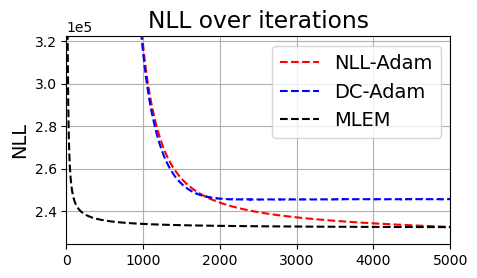

In [6]:
plt.rcParams.update({'font.size': 14})

cutoff = 0 #500  # Cutoff for the x-axis

x_values = list(range(0, epochs, 1))

x_values_dist = x_values[:len(states["dist"]["losses"]["nll_loss"])]

# Plot the NLL losses
fig, ax = plt.subplots(1, 1, figsize=(5,3))

ax.set_xlim(cutoff, x_values[-1])
ymin = states["nll"]["losses"]["nll_loss"][2000:].min()
ymax = max(states["mlem"]["losses"]["nll_loss"][1000:].max(), states["dist"]["losses"]["nll_loss"][1000:].max())
ax.set_ylim(ymin - (ymax-ymin)*0.1, ymax + (ymax-ymin)*0.1 )

ax.plot(x_values[cutoff:], states["nll"]["losses"]["nll_loss"][cutoff:], label="NLL-Adam", color='red', linestyle='--')
ax.plot(x_values_dist[cutoff:], states["dist"]["losses"]["nll_loss"][cutoff:], label="DC-Adam", color='blue', linestyle='--')
ax.plot(x_values[cutoff:], states["mlem"]["losses"]["nll_loss"][cutoff:], label="MLEM", color='black', linestyle='--')

ax.tick_params(axis='both', labelsize=10)
ax.ticklabel_format(axis='y', style="sci", scilimits=(0,0))
ax.set_title("NLL over iterations")
ax.yaxis.get_offset_text().set_fontsize(10)
ax.set_ylabel("NLL")
ax.grid(True)
ax.legend()
plt.tight_layout()

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_NLL_loss.svg"))

plt.show()

### Plot DC loss

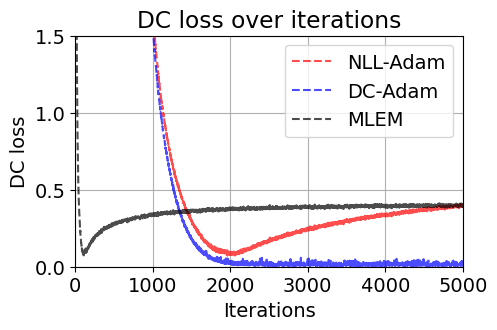

In [7]:
# Plot the loss curves
plt.rcParams.update({'font.size': 14})
cutoff = 0  # Cutoff for the x-axis

x_values = list(range(0, epochs, 1))

x_values_dist = x_values[:len(states["dist"]["losses"]["dist_loss"])]

# Plot the NLL losses
fig,ax = plt.subplots(1, 1, figsize=(5,3))

ax.set_xlim(cutoff, x_values[-1])
ax.set_ylim(0, 1.5)

ax.plot(x_values[cutoff:], states["nll"]["losses"]["dist_loss"][cutoff:], label="NLL-Adam", color='red', linestyle='--', alpha=0.7)
ax.plot(x_values_dist[cutoff:], states["dist"]["losses"]["dist_loss"][cutoff:], label="DC-Adam", color='blue', linestyle='--', alpha=0.7)
ax.plot(x_values[cutoff:], states["mlem"]["losses"]["dist_loss"][cutoff:], label="MLEM", color='black', linestyle='--', alpha=0.7)

ax.set_title("DC loss over iterations")
ax.set_xlabel("Iterations")
ax.set_ylabel("DC loss")
ax.legend()
ax.grid(True)

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_DC_loss.svg"))

plt.show()

### Plot histograms of CDF values of measurements (with respect to the predicted distributions given by the estimated measurements) 

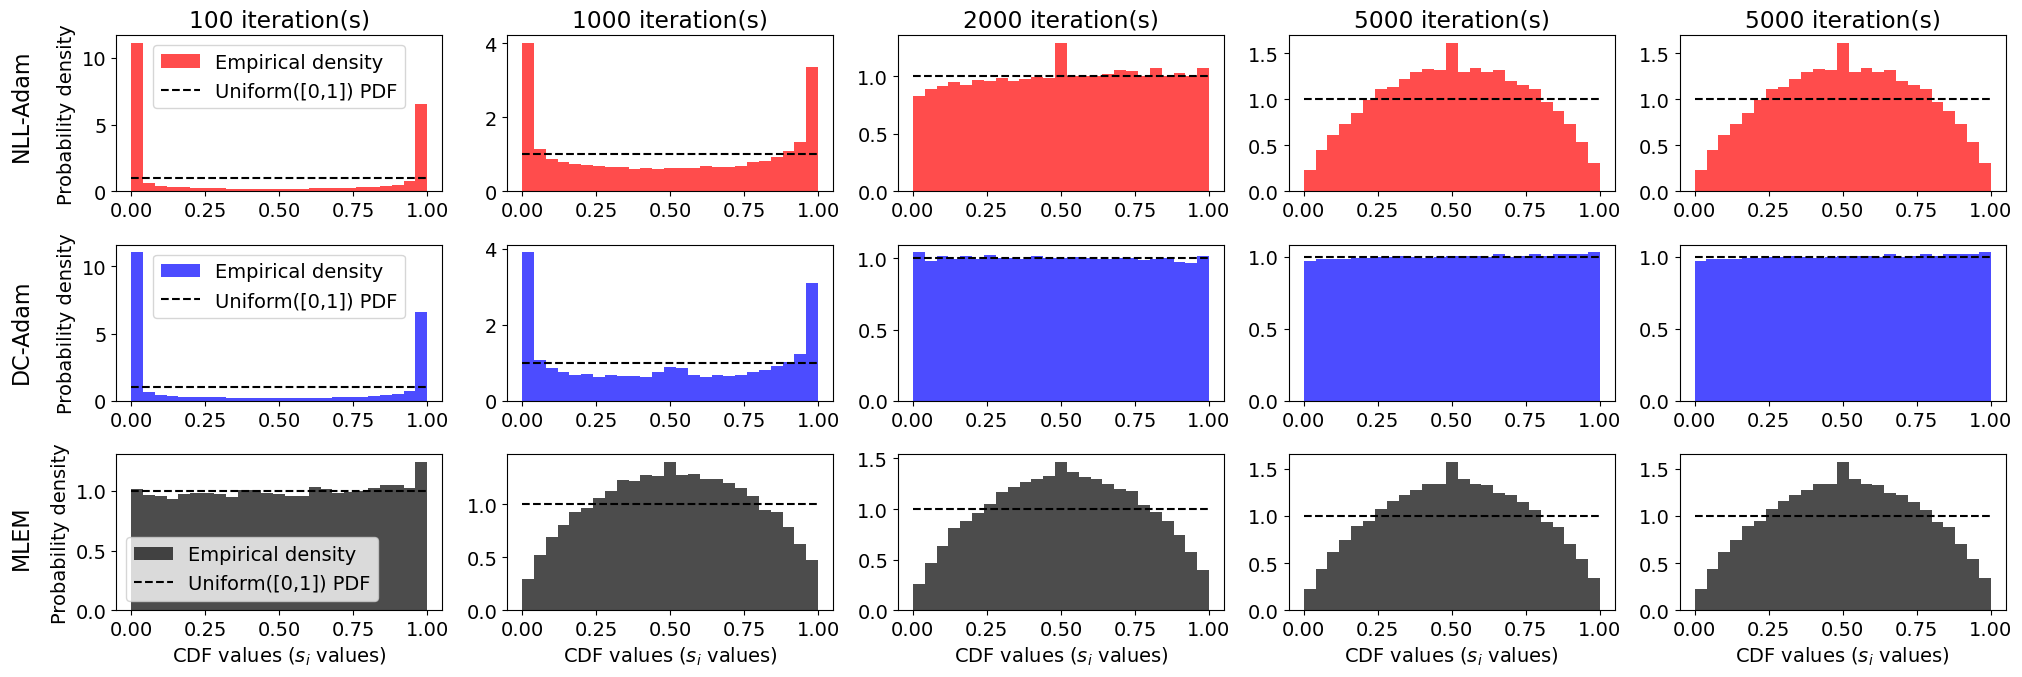

In [8]:
iters = [100, 1000, 2000, 5000, epochs-1] # 2000, 5000]

fig,ax = plt.subplots(3,len(iters), figsize=(20,7))

#iters = [0,1,2,3,4]

for j, _loss_name in enumerate(["nll", "dist", "mlem"]):
    state = states[_loss_name]
    for i in range(len(iters)):
        if j == 0:
            color = 'red'
        elif j == 1:
            color = 'blue'
        else:
            color = 'black'
        ax[j,i] = plot_CDF_histogram(ax[j,i], state["histos"][iters[i] // 100][0], comparison="uniform", show_comparison=True, bins=25, color=color, alpha=0.7, label='Empirical density')
        if j ==0:
            ax[j,i].set_title(f"{iters[i]} iteration(s)")
        if j != 2:
            ax[j,i].set_xlabel("")
        if i != 0:
            ax[j, i].legend().set_visible(False)
            ax[j,i].set_ylabel("")


# Add labels to the left of the subplots
fig.text(-0.01, 5/6., "NLL-Adam", fontsize=16, va='center', rotation='vertical')
fig.text(-0.01, 3/6.+0.01, "DC-Adam", fontsize=16, va='center', rotation='vertical')
fig.text(-0.01, 1./6. + 0.05, "MLEM", fontsize=16, va='center', rotation='vertical')

plt.tight_layout()

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_histograms.svg"))
plt.show()

### Plot images

C:\Users\gw23\AppData\Local\Temp\ipykernel_48020\1246265776.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


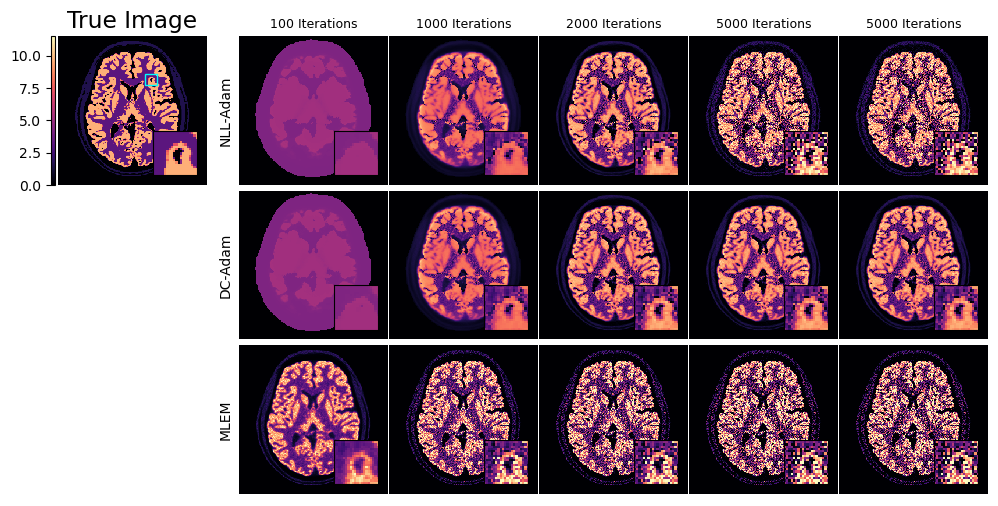

In [9]:
# y,x
zoom_coords = (74-10,159-10) # (20, 40) for 256x256, (10, 20) for 128x128
#zoom_coords = (90-10,173-10)
cmap = "magma"

fig = plt.figure(figsize=(12, 6)) # , dpi=600

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def add_inset_cutout(ax, image, zoom_coords=(10, 10), patch_size=20, vmin=0, vmax=1):
    """
    Adds a zoomed inset to the top right corner of a subplot.
    
    Parameters:
        ax : The main axis to add the inset to.
        image : The 2D image array.
        zoom_coords : Tuple (row, col) of the top-left corner of the zoomed patch.
        patch_size : The size of the square zoomed patch.
    """
    r0, c0 = zoom_coords
    patch = image[r0:r0 + patch_size, c0:c0 + patch_size]
    
    ax_inset = inset_axes(ax, width="30%", height="30%", loc='lower right',
                          bbox_to_anchor=(0, 0, 1, 1), bbox_transform=ax.transAxes, borderpad=0.5)
    ax_inset.imshow(patch, cmap=cmap, vmin=vmin, vmax=vmax)
    ax_inset.set_xticks([]); ax_inset.set_yticks([])

vmin=0.0
vmax = phantom.max() * 1.2

# Define the width ratios: [left column, spacer, main grid]
gs = GridSpec(3, len(iters) + 2, width_ratios=[1, 0.2] + [1]*len(iters), wspace=0.01, hspace=0.01)
plt.tight_layout()

# True and Noisy images
ax_true = fig.add_subplot(gs[0, 0])

im_true = ax_true.imshow(phantom.cpu().squeeze(), cmap=cmap, vmin=vmin, vmax=vmax)
ax_true.set_title("True Image")

rect = patches.Rectangle((zoom_coords[1], zoom_coords[0]), 20, 20, linewidth=1.0, edgecolor='cyan', facecolor='none')
ax_true.add_patch(rect)

ax_true.axis("off")
add_inset_cutout(ax_true, phantom.cpu().squeeze(), zoom_coords=zoom_coords, patch_size=20, vmin=vmin, vmax=vmax)

# colour-bar (3 % width, half-height, to the right of the image)
cax = inset_axes(ax_true,
                 width="3%", height="100%",  # width, height
                 loc='lower left',
                 bbox_to_anchor=(-0.05, 0., 1, 1),
                 bbox_transform=ax_true.transAxes,
                 borderpad=0)
cbar = fig.colorbar(im_true, cax=cax, orientation='vertical')
cbar.ax.tick_params(labelsize=10)
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_label_position('left')
cbar.ax.tick_params(labelright=False, labelleft=True)

# Iteration images + y-axis labels
for j, loss_name in enumerate(["nll", "dist", "mlem", ]):
    state = states[loss_name]
    
    # Add label axes (next to the first iteration image)
    ax_label = fig.add_subplot(gs[j, 2])
    hide(ax_label)
    if loss_name == "nll":
        ax_label.set_ylabel("NLL-Adam", 
                            fontsize=10, labelpad=10, rotation=90, va='center')
    elif loss_name == "mlem":
        ax_label.set_ylabel("MLEM", 
                            fontsize=10, labelpad=10, rotation=90, va='center')
    else:
        ax_label.set_ylabel("DC-Adam",
                        fontsize=10, labelpad=10, rotation=90, va='center')

    # Plot images in grid
    for i, iteration in enumerate(iters):
        ax_img = fig.add_subplot(gs[j, i + 2])  # +2 to skip first col and spacer
        ax_img.imshow(state["images"][iteration // 10], cmap=cmap, vmin=vmin, vmax=vmax)
        if j == 0:
            ax_img.set_title(f"{iteration} Iterations", fontsize=9)
        hide(ax_img)

        
        # Add inset cutout (you can change zoom_coords and patch_size as needed)
        add_inset_cutout(ax_img, state["images"][iteration // 10], zoom_coords=zoom_coords, patch_size=20, vmin=vmin, vmax=vmax)

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_images.svg"), dpi=600)
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_images_lower.svg"), dpi=300)
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_images_lowest.svg"), dpi=150)
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_images.png"), dpi=600)
plt.tight_layout()
plt.show()


### Plot PSNR

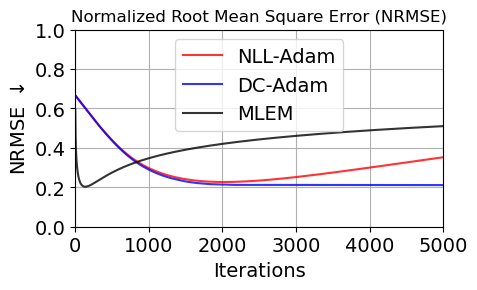

In [10]:
# Plot the PSNR curves

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

cutoff = 0  # Cutoff for the x-axis

x_values = list(range(0, epochs, 1))

x_values_dist = x_values[:len(states["dist"]["losses"]["nrmse"])]

ax.set_xlim(cutoff, x_values[-1])

ax.set_ylim(0, 1.0)

ax.plot(x_values, states["nll"]["losses"]["nrmse"], label="NLL-Adam", color='red', alpha=0.8)
ax.plot(x_values_dist, states["dist"]["losses"]["nrmse"], label="DC-Adam", color='blue', alpha=0.8)
ax.plot(x_values, states["mlem"]["losses"]["nrmse"], label="MLEM", color='black', alpha=0.8)

ax.set_xlabel("Iterations")
ax.set_ylabel(r"NRMSE $\downarrow$")

ax.legend()
plt.tight_layout()
ax.grid(True)
ax.set_title("Normalized Root Mean Square Error (NRMSE)", fontsize=12)

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_NRMSE.svg"), dpi=600)
plt.show()


#### Plot SSIM

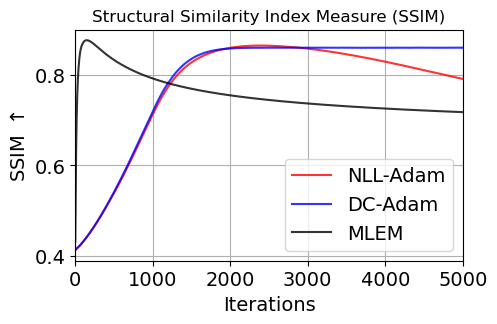

In [11]:
# Plot the SSIM curves

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

cutoff = 0  # Cutoff for the x-axis

x_values = list(range(0, epochs, 1))

x_values_dist = x_values[:len(states["dist"]["losses"]["ssim"])]

ax.set_xlim(cutoff, x_values[-1])

ax.plot(x_values, states["nll"]["losses"]["ssim"], label="NLL-Adam", color='red', alpha=0.8)
ax.plot(x_values_dist, states["dist"]["losses"]["ssim"], label="DC-Adam", color='blue', alpha=0.8)
ax.plot(x_values, states["mlem"]["losses"]["ssim"], label="MLEM", color='black', alpha=0.8)

ax.set_xlabel("Iterations")
ax.set_ylabel(r"SSIM $\uparrow$")

ax.grid(True)
ax.set_title("Structural Similarity Index Measure (SSIM)", fontsize=12)
ax.legend()

if SAVEFIG:
    plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_SSIM.png"), dpi=600)
plt.show()


### Plot CDF histograms of noisy and noise-free measurements (for different dose levels)

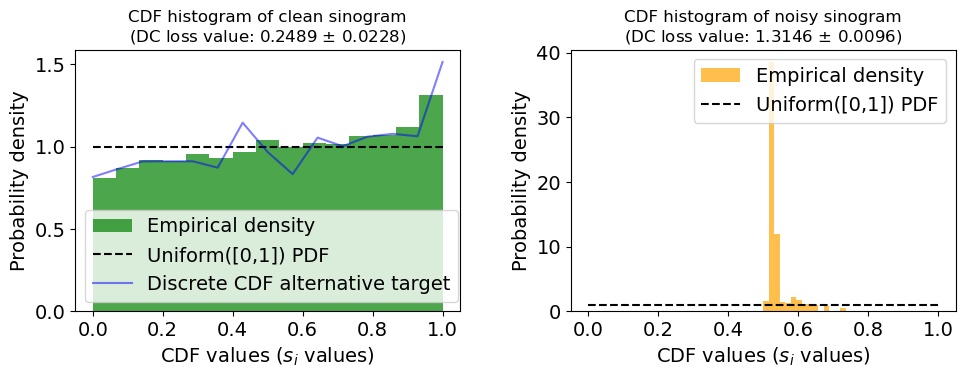

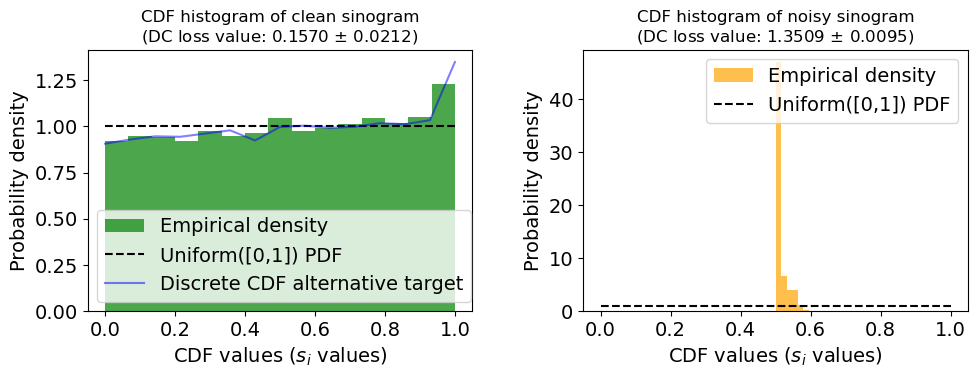

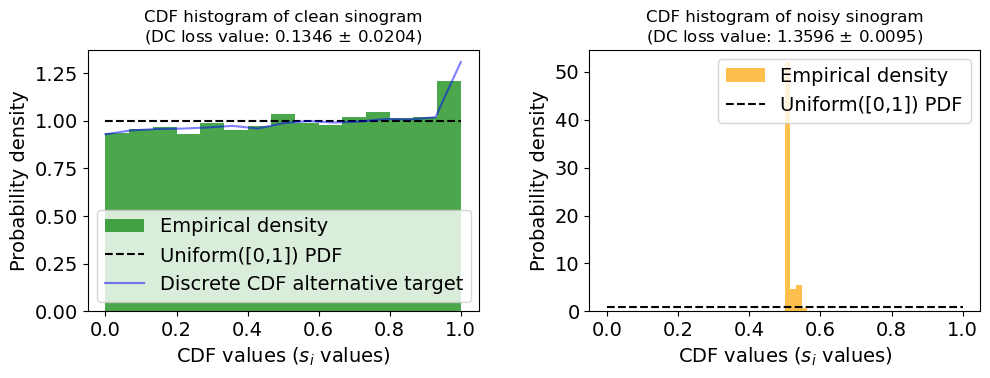

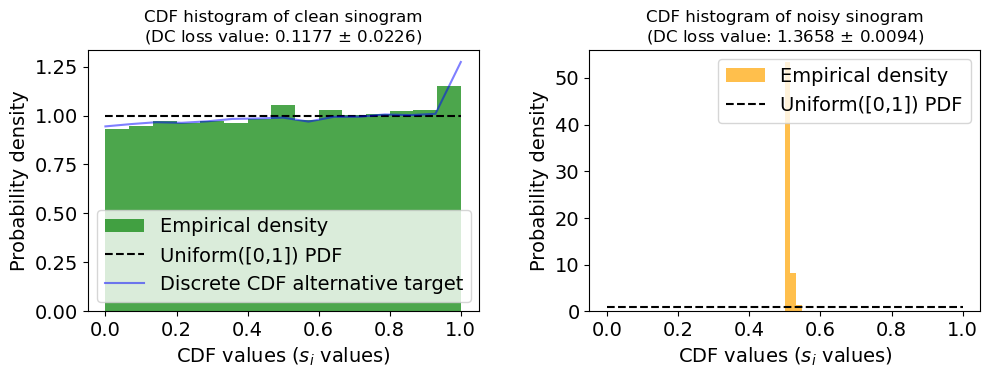

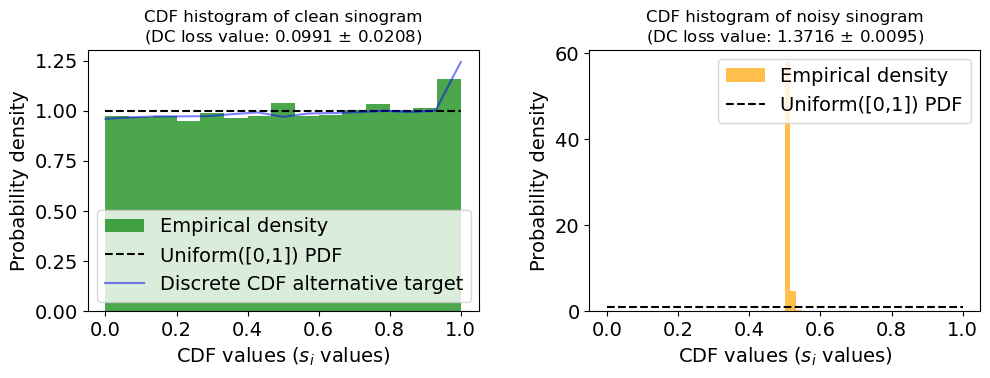

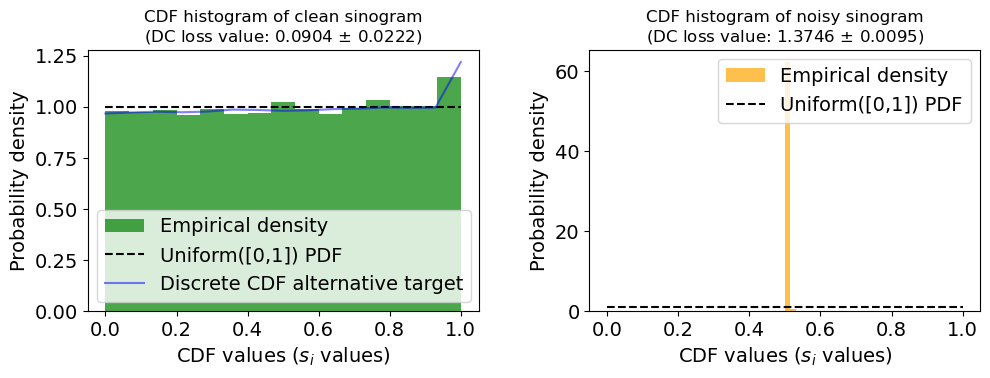

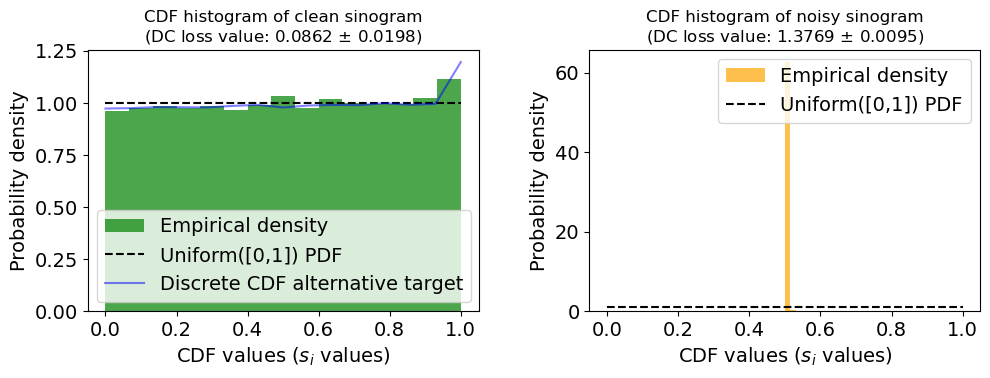

In [12]:
seed_start = 1

gt = phantom.detach().cpu().numpy().squeeze()
projector = get_projector(dev, IMG_SIZE, ring_factor=4.0)
A = get_binmashed_projector_forward_function(projector, 2)
AT = get_binmashed_projector_adjoint_function(projector, 2)

nonzero_mask = (phantom.numpy() != 0).astype(np.uint8)
mumap = binary_fill_holes(nonzero_mask).astype(np.uint8)
mumap = torch.tensor(mumap).to(dev)

mask = mumap > 0
mask = mask.to(torch.float64)

sino_mask = A(mask).flatten()
sino_mask = sino_mask > 1e-2

for _dose in [0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]:

    mean_dist_loss_clean = []
    mean_dist_loss_noisy = []
    adjustment = []

    gt_dose = torch.tensor(gt[None, None, ..., None]).to(dev).to(torch.float64) * _dose

    dose_clean_sinogram = A(gt_dose).to(torch.float64)
    
    for seed in range(seed_start, seed_start+100):
        fix_seed(seed)
        dose_noisy_sinogram = torch.tensor(np.random.poisson(dose_clean_sinogram.cpu().numpy())).to(dev).to(torch.float64)

        m = torch.nn.functional.relu(dose_noisy_sinogram.flatten()[sino_mask]) + 1e-16
        clean_m = torch.nn.functional.relu(dose_clean_sinogram.flatten()[sino_mask]) + 1e-16


        dist_loss_value_clean, histo_values_clean, ix_clean = dc_loss_poisson(clean_m, m, return_values=True)
        mean_dist_loss_clean.append(dist_loss_value_clean.item())
        
        dist_loss_value_noisy, histo_values_noisy, ix_noisy = dc_loss_poisson(m, m, return_values=True)
        mean_dist_loss_noisy.append(dist_loss_value_noisy.item())

    for seed in range(seed_start+100, seed_start+200):
        fix_seed(seed)
        sample = np.random.poisson(dose_noisy_sinogram.cpu().numpy()).flatten()
        adj = scipy.stats.poisson.cdf(sample, dose_noisy_sinogram.cpu().numpy().flatten()).flatten()[sino_mask.cpu().numpy()]
        adjustment.append(adj)

    mean_dist_loss_clean = np.array(mean_dist_loss_clean)
    mean_dist_loss_noisy = np.array(mean_dist_loss_noisy)
    adjustment = np.array(adjustment)

    adjustment_hist = np.histogram(adjustment, bins=np.linspace(0,1,16), density=True)[0]

    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    # Clean image subplot
    ax[0] = plot_CDF_histogram(ax[0], histo_values_clean.cpu().numpy(), comparison="uniform", show_comparison=True, bins=np.linspace(0,1,16), color='green', alpha=0.7, label='Empirical density')
    ax[0].set_title("CDF histogram of clean sinogram\n(DC loss value: " + rf"{mean_dist_loss_clean.mean():.4f} $\pm$ {mean_dist_loss_clean.std() * 1.96:.4f})", fontsize=12)
    ax[0].plot(np.linspace(0,1,15), adjustment_hist, color='blue', alpha=0.5, label='Discrete CDF alternative target')
    ax[0].legend(loc = "lower left")

    # Noisy image subplot
    ax[1] = plot_CDF_histogram(ax[1], histo_values_noisy.cpu().numpy(), comparison="uniform", show_comparison=True, bins=15, color='orange', alpha=0.7, label='Empirical density')
    ax[1].set_title("CDF histogram of noisy sinogram\n(DC loss value: " + rf"{mean_dist_loss_noisy.mean():.4f} $\pm$ {mean_dist_loss_noisy.std() * 1.96:.4f})", fontsize=12)
    
    #plt.suptitle(f"Histogram of CDF values for N={N}", fontsize=14)

    plt.tight_layout()
    if SAVEFIG:
        plt.savefig(os.path.join(save_directory, f"IMG_SIZE_{IMG_SIZE}_PET_histograms_dose={_dose}.svg"), dpi=600)
    #plt.clf(); plt.close()
    plt.show()